# Case 1 - Ordinary Least Squares (OLS), Ridge Regression, and Elastic-Net Regression

1. **Importing Libraries**

2. **Loading Data**

3. **Ordinary Least Squares (OLS)**

4. **Ridge (L2) Regression**

5. **Lasso (L1) Regression**

6. **Elastic Net Regression**
- Elastic Net Regression because we have many variables that we do not know. Elastic Net combines the strengths of Lasso regression (L1) and Ridge regression. Lasso regression can shrink parameters to 0 which is useful for large dataset where some parameters might be useless. Ridge regression tends to perform better when parameters are not useless. Therefore, elastic net is useful in this case as we do not know our parameters.
- Find optimal model parameters, lamdba_1 and lambda_2 by using 5-fold cross validation.
- Get root mean squared error (RMSE) by applying the model with the optimal model parameters on the test data.

## 1. Importing Libraries

In [41]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set searborn as default

import scipy . linalg as lng

from sklearn import linear_model

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

import warnings

# Set seed for reproducibility
import random
random.seed(42)

## 2. Loading Data

In [42]:
# Loading the data into numpy arrays
X_train = np.loadtxt('../data/case1Data_Xtrain.csv', delimiter=',')
X_test = np.loadtxt('../data/case1Data_Xtest.csv', delimiter=',')
y_train = np.loadtxt('../data/case1Data_ytrain.csv', delimiter=',')
y_test = np.loadtxt('../data/case1Data_ytest.csv', delimiter=',')

### Summary of the data

This should be similar to the summary in case_1_data_wrangling.ipynb.

In [43]:
# Printing the shape of the data
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

# Size of the training and test data
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]

# Printing the size of the training and test data
print("n_train: ", n_train) # number of training samples
print("n_test: ", n_test) # number of test samples
print("p: ", p) # number of features/variables/columns/parameters

# Checking for missing values in the wrangled data
missing_values_X_train = np.isnan(X_train)
print("Number of missing values in X_train: ", np.sum(missing_values_X_train))
missing_values_X_test = np.isnan(X_test)
print("Number of missing values in X_test: ", np.sum(missing_values_X_test))
missing_values_y_train = np.isnan(y_train)
print("Number of missing values in y_train: ", np.sum(missing_values_y_train))
missing_values_y_test = np.isnan(y_test)
print("Number of missing values in y_test: ", np.sum(missing_values_y_test))

X_train:  (80, 116)
X_test:  (20, 116)
y_train:  (80,)
y_test:  (20,)
n_train:  80
n_test:  20
p:  116
Number of missing values in X_train:  0
Number of missing values in X_test:  0
Number of missing values in y_train:  0
Number of missing values in y_test:  0


#### SELECTING FEATURES WITH BIC

In [44]:
def compute_bic(X, y, model):
    """Compute Bayesian Information Criterion (BIC) for a given model."""
    n, k = X.shape  # n = samples, k = features
    model.fit(X, y)
    residuals = y - model.predict(X)
    rss = np.sum(residuals**2)  # Residual sum of squares
    sigma2 = rss / n  # Estimated variance
    bic = n * np.log(sigma2) + k * np.log(n)  # BIC formula
    return bic

def stepwise_bic_selection(X, y):
    """Greedy forward selection based on BIC."""
    n_features = X.shape[1]
    selected_features = []  # Start with an empty set
    best_bic = np.inf
    model = LinearRegression()

    while True:
        bic_scores = []
        candidates = [i for i in range(n_features) if i not in selected_features]

        # Try adding each remaining feature
        for feature in candidates:
            current_features = selected_features + [feature]
            bic = compute_bic(X[:, current_features], y, model)
            bic_scores.append((feature, bic))

        # Select the feature that minimizes BIC
        bic_scores.sort(key=lambda x: x[1])
        best_new_feature, new_bic = bic_scores[0]

        # Stop if BIC does not improve
        if new_bic >= best_bic:
            break

        # Otherwise, update the best BIC and selected features
        best_bic = new_bic
        selected_features.append(best_new_feature)

    return selected_features, best_bic

# Run BIC feature selection
best_features, best_bic = stepwise_bic_selection(X_train, y_train)

print("Selected Feature Indices:", best_features)
print("Best BIC Score:", best_bic)

Selected Feature Indices: [31, 61, 35, 53, 67, 36, 81, 48, 9, 38, 77, 74, 104]
Best BIC Score: 492.75769252942996


#### SELECTING FEATURES WITH LASSO

In [45]:
from sklearn.feature_selection import SelectFromModel

lasso = LassoCV(cv=3, random_state=42) # LassoCV automatically performs cross-validation
lasso.fit(X_train, y_train) # Fit the model on the training data

# Select important features (nonzero coefficients)
selector = SelectFromModel(lasso, prefit=True) # Use the Lasso model to select features
selected_features_mask = selector.get_support()
selected_features = np.where(selected_features_mask)[0]  # Get indices of selected features

print("Selected Feature Indices:", selected_features)

Selected Feature Indices: [  6   8   9  10  12  27  28  29  31  34  35  40  42  44  48  50  53  54
  56  58  61  63  67  72  74  75  77  81  82  85 112]


# Models

## 4. Ordinary Least Squares (OLS)

In [46]:
# Function to solve the OLS
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    return betas, res, rnk, s

# Fitting the OLS model on the training data
betas, residuals, rnk, s = ols_solver(X_train, y_train)

# Predicting the target values on the test data by multiplying the test data with the betas from the OLS model
y_hat = X_test @ betas

# Calculating the root mean squared error (RMSE) of the OLS model
#rmse = np.sqrt(np.mean((y_test - y_hat)**2))
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the residual mean squared error (RMSE) of the OLS model
print(f'RMSE: {rmse}')

RMSE: 33.42900758727703


#### WITH BIC FEATURES

In [47]:
# Function to solve the OLS
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    return betas, res, rnk, s

# Fitting the OLS model on the training data with the selected features
betas, residuals, rnk, s = ols_solver(X_train[:, best_features], y_train)

# Predicting the target values on the test data by multiplying the test data with the betas from the OLS model
y_hat = X_test[:, best_features] @ betas

# Calculating the root mean squared error (RMSE) of the OLS model
#rmse = np.sqrt(np.mean((y_test - y_hat)**2))
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the residual mean squared error (RMSE) of the OLS model
print(f'RMSE: {rmse}')

RMSE: 186.06870899274725


#### WITH LASSO FEATURES

In [48]:
# Function to solve the OLS
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    return betas, res, rnk, s

# Fitting the OLS model on the training data with the selected features
betas, residuals, rnk, s = ols_solver(X_train[:, selected_features], y_train)

# Predicting the target values on the test data by multiplying the test data with the betas from the OLS model
y_hat = X_test[:, selected_features] @ betas

# Calculating the root mean squared error (RMSE) of the OLS model
#rmse = np.sqrt(np.mean((y_test - y_hat)**2))
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the residual mean squared error (RMSE) of the OLS model
print(f'RMSE: {rmse}')

RMSE: 233.5226915320538


# 4. Ridge (L2) Regression

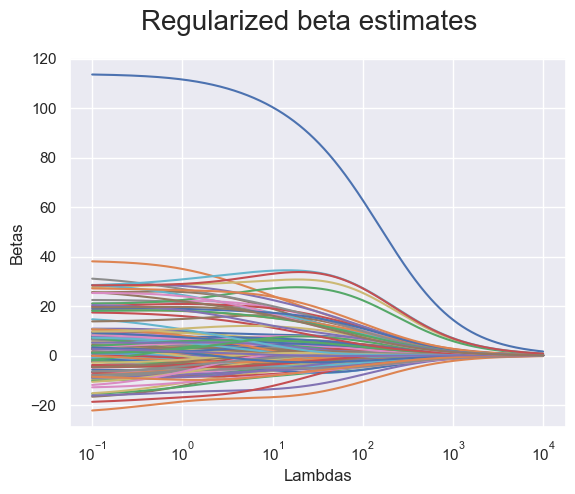

In [49]:
# Function to solve the ridge regression
def ridge(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p)) # (X^T*X + lambda*I)^-1
    outer_prod = X.T @ y # X^T*y
    betas = inner_prod @ outer_prod # (X^T*X + lambda*I)^-1 * X^T*y
    return betas

# Setting k for the number of lambdas to test
k = 1000

# Creating a list of lambdas to test
lambdas = np.logspace(-1, 4, k)

# Creating a matrix to store the beta estimates for each lambda
betas = np.zeros((p, k))

# Fitting the ridge regression model on the training data for each lambda
for i in range(k):
    betas[:, i] = ridge(X_train, lambdas[i], p, y_train)

# Plotting the regularized beta estimates
plt.close('all')
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()


In [50]:
# Setting k for the number of lambdas to test
k = 1000

# Creating a list of lambdas to test
lambdas = np.logspace(-1, 4, k)

# Performing RidgeCV with leave-one-out cross-validation
#ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=n_train)

# Performing RidgeCV with 5-fold cross-validation
ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=3)

# Fitting the RidgeCV model on the training data
ridge_cv.fit(X_train, y_train)

# Optimal lambda from RidgeCV with 5-fold cross-validation (alpha_)
lambda_OP = ridge_cv.alpha_

#print optimal lambda
print(f'Optimal lambda: {lambda_OP}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal lambda: 4.3314832233764005


In [51]:
# Estimating the target values on the test data
y_hat = ridge_cv.predict(X_test)

# Calculating the RMSE of the RidgeCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('Root MSE from OLS with ridge regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

Root MSE from OLS with ridge regression and cross validation to find optimal lambda and model parameters:
RMSE: 31.87251443860696


#### WITH BIC FEATURES

In [52]:
# Setting k for the number of lambdas to test
k = 1000

# Creating a list of lambdas to test
lambdas = np.logspace(-1, 4, k)

# Performing RidgeCV with leave-one-out cross-validation
#ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=n_train)

# Performing RidgeCV with 5-fold cross-validation
ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=3)

# Fitting the RidgeCV model on the training data
ridge_cv.fit(X_train[:, best_features], y_train)

# Optimal lambda from RidgeCV with 5-fold cross-validation (alpha_)
lambda_OP = ridge_cv.alpha_

#print optimal lambda
print(f'Optimal lambda: {lambda_OP}')

# Estimating the target values on the test data
y_hat = ridge_cv.predict(X_test[:, best_features])

# Calculating the RMSE of the RidgeCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('Root MSE from OLS with ridge regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal lambda: 1.291549665014884
Root MSE from OLS with ridge regression and cross validation to find optimal lambda and model parameters:
RMSE: 28.722856273317145


#### WITH LASSO FEATURES

In [53]:
# Setting k for the number of lambdas to test
k = 1000

# Creating a list of lambdas to test
lambdas = np.logspace(-1, 4, k)

# Performing RidgeCV with leave-one-out cross-validation
#ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=n_train)

# Performing RidgeCV with 5-fold cross-validation
ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=3)

# Fitting the RidgeCV model on the training data
ridge_cv.fit(X_train[:, selected_features], y_train)

# Optimal lambda from RidgeCV with 5-fold cross-validation (alpha_)
lambda_OP = ridge_cv.alpha_

#print optimal lambda
print(f'Optimal lambda: {lambda_OP}')

# Estimating the target values on the test data
y_hat = ridge_cv.predict(X_test[:, selected_features])

# Calculating the RMSE of the RidgeCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('Root MSE from OLS with ridge regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal lambda: 1.6835508029612023
Root MSE from OLS with ridge regression and cross validation to find optimal lambda and model parameters:
RMSE: 27.88911468047865


# 5. Lasso (L1) Regression

In [54]:
lasso = LassoCV(cv=3, random_state=42)
lasso.fit(X_train, y_train)

# Optimal lambda from LassoCV with 3-fold cross-validation (alpha_)
lambda_OP = lasso.alpha_
print(f'Optimal lambda: {lambda_OP}')

y_hat = lasso.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('Root MSE from OLS with lasso regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

Optimal lambda: 1.1047649897957665
Root MSE from OLS with lasso regression and cross validation to find optimal lambda and model parameters:
RMSE: 27.10916268579508


#### WITH BIC FEATURES

In [55]:
lasso = LassoCV(cv=3, random_state=42)
lasso.fit(X_train[:, best_features], y_train)

# Optimal lambda from LassoCV with 3-fold cross-validation (alpha_)
lambda_OP = lasso.alpha_
print(f'Optimal lambda: {lambda_OP}')

y_hat = lasso.predict(X_test[:, best_features])

rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('Root MSE from OLS with lasso regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

Optimal lambda: 0.7268615922251137
Root MSE from OLS with lasso regression and cross validation to find optimal lambda and model parameters:
RMSE: 27.848751636959705


# 6. Elastic Net Regression

In [56]:
# Setting a range of alphas to test
alphas = np.logspace(-4, 0, 100)

# Setting a range of l1_ratios
l1_ratios = np.logspace(-10, 0, 100)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    # Fitting the Elastic Net model on the training data
    model = linear_model.ElasticNetCV(cv=3, l1_ratio = l1_ratios, alphas=alphas, fit_intercept=False).fit(X_train, y_train)

# Printing the optimal alpha
print(f'Optimal alpha: {model.alpha_}\n')
print('For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.')
print(f'Optimal l1_ratio: {model.l1_ratio_}')

# Plotting the cross-validated mean squared error of the Elastic Net Fit
#plt.close('all')
#plt.figure()
#plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k', label='Average across folds', linewidth=2)
#plt.xlabel(r'$\alpha$ (Regularization strength)')
#plt.ylabel('Mean squared error')
#plt.title(f'Cross-validated MSE of Elastic Net Fit (Optimal alpha = {model.alpha_:.3f})')
#plt.show()

Optimal alpha: 0.9111627561154896

For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
Optimal l1_ratio: 1.0


In [57]:
# Using the optimal lambda from the ElasticNetCV model to predict the target values on the test data
y_hat = model.predict(X_test)

# Calculating the RMSE of the ElasticNetCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the RMSE
print('Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:
RMSE: 26.094967036910088


#### WITH BIC FEATURES

In [58]:
# Setting a range of alphas to test
alphas = np.logspace(-4, 0, 100)

# Setting a range of l1_ratios
l1_ratios = np.logspace(-10, 0, 100)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    # Fitting the Elastic Net model on the training data
    model = linear_model.ElasticNetCV(cv=3, l1_ratio = l1_ratios, alphas=alphas, fit_intercept=False).fit(X_train[:, best_features], y_train)

# Printing the optimal alpha
print(f'Optimal alpha: {model.alpha_}\n')
print('For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.')
print(f'Optimal l1_ratio: {model.l1_ratio_}')

# Using the optimal lambda from the ElasticNetCV model to predict the target values on the test data
y_hat = model.predict(X_test[:, best_features])

# Calculating the RMSE of the ElasticNetCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the RMSE
print('Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

Optimal alpha: 1.0

For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
Optimal l1_ratio: 1e-10
Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:
RMSE: 202.01203533525927


#### WITH LASSO FEATURES

In [59]:
# Setting a range of alphas to test
alphas = np.logspace(-4, 0, 100)

# Setting a range of l1_ratios
l1_ratios = np.logspace(-10, 0, 100)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    # Fitting the Elastic Net model on the training data
    model = linear_model.ElasticNetCV(cv=3, l1_ratio = l1_ratios, alphas=alphas, fit_intercept=False).fit(X_train[:, selected_features], y_train)

# Printing the optimal alpha
print(f'Optimal alpha: {model.alpha_}\n')
print('For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.')
print(f'Optimal l1_ratio: {model.l1_ratio_}')

# Using the optimal lambda from the ElasticNetCV model to predict the target values on the test data
y_hat = model.predict(X_test[:, selected_features])

# Calculating the RMSE of the ElasticNetCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the RMSE
print('Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

Optimal alpha: 1.0

For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
Optimal l1_ratio: 1e-10
Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:
RMSE: 201.65717228803064
